# Лабораторная работа №4 (проведение исследований с алгоритмом RandomForest)

In [3]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

## 1. Выбор начальных условий
### Набор данных для классификации

In [4]:
glass_dataset = fetch_ucirepo(id=42)


In [5]:
df = pd.DataFrame(data=glass_dataset.data.features)
df['Glass'] = glass_dataset.data.targets

In [6]:
target_column = "Glass"

class_names = [
    "building_windows_float_processed",
    "building_windows_non_float_processed",
    "vehicle_windows_float_processed",
    "vehicle_windows_non_float_processed",
    "containers",
    "tableware",
    "headlamps",
    ]

# df[target_column] = df[target_column].apply(lambda x: class_names[x-1])
# df[target_column].head()

Разобьем выборку на обучающую и валидационную

In [7]:
train, valid = train_test_split(df, train_size=0.8, random_state=42, shuffle=True, stratify=df[target_column])

In [8]:
X_train = train.drop(columns=target_column, inplace=False)
y_train = train[target_column]

X_valid = valid.drop(columns=target_column, inplace=False)
y_valid = valid[target_column]

## 2. Создание бейзлайна и оценка качества

### Обучение модели

Определим модель и обучим модель

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Сделаем предсказания

In [10]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### Оценка качества модели

У нас мультиклассовая классификация, но класс `vehicle_windows_non_float_processed` отсутствует среди истинных меток классов

In [11]:
df[target_column].nunique()

6

Поэтому метрики будем вычислять, используя параметры `average='macro'` и `zero_division=1` 

In [12]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [13]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,1.0,0.837404
1,Balanced Accuracy,1.0,0.832540
2,Precision,1.0,0.879588
3,Recall,1.0,0.832540


Визуализируем метрики

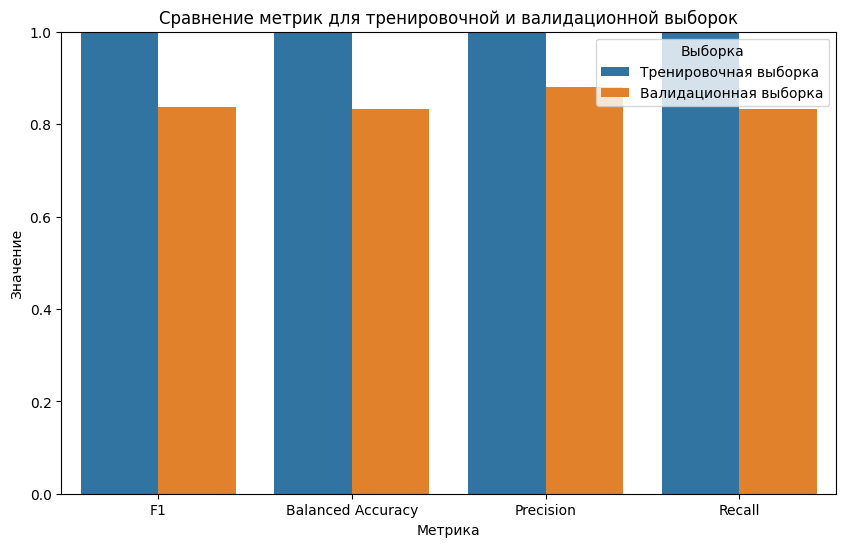

In [14]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

## 3. Улучшение бейзлайна

### Препроцессинг данных

In [15]:
df_optimized = df.copy()

Найден дубликат, удалим его

In [16]:
df_optimized = df_optimized.drop_duplicates()

In [17]:
# Обработка выбросов
def remove_outliers(data, columns, threshold=1.5):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df_optimized = remove_outliers(df_optimized, df_optimized.columns)

In [18]:
X = df_optimized.drop(target_column, axis=1)
y = df_optimized[target_column]

Скалирование данных

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Балансировка классов

In [20]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [21]:
new_X_train, new_X_valid, new_y_train, new_y_valid = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
    )


Решим проблему высокой корреляции данных

In [22]:
pca = PCA(n_components=new_X_train.shape[1])
pca.fit(new_X_train)

PCA(n_components=9)

Проверим сколько компонент дают 90% дисперсии

In [23]:
pca.explained_variance_ratio_.round(2)

array([0.27, 0.23, 0.15, 0.13, 0.1 , 0.06, 0.05, 0.  , 0.  ])

Достаточно 7-и компонент

### Обучение модели с новыми данными

Переопределим модель

In [24]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42))
))

In [25]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model', RandomForestClassifier(random_state=42))])

Сделаем предсказания

In [26]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### Оценка качетсва модели с улучшеным бейзлайном

In [27]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [28]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,1.0,0.931579
1,Balanced Accuracy,1.0,0.933333
2,Precision,1.0,0.939394
3,Recall,1.0,0.933333


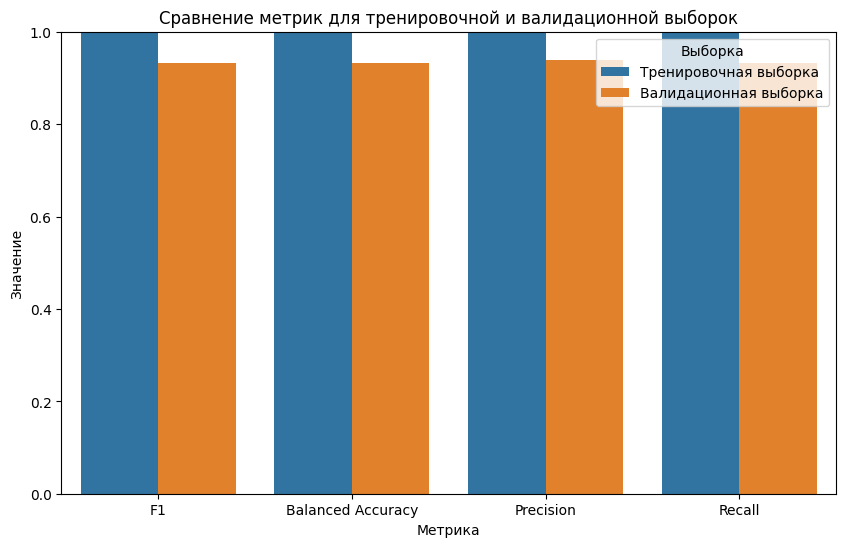

In [29]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Резюме:
На качество модели повлияли, как входные данные, так и параметры самой модели:
- При помощи квантилей я удалил выбросы
- Скалировал данные StandartScaller'ом
- Избавился от дисбалана классов
- Избавился от высокой кореляции фичей

## 4. Имплементация алгоритма машинного обучения

### Реализация модели

Импортируем модель

In [30]:
from RForest import MyRandomForestClassifier

### Обучение 

In [31]:
model = MyRandomForestClassifier()
model.fit(X_train, y_train)

In [32]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

###  Оценка качества модели

In [33]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro', zero_division=1)

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro', zero_division=1)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [34]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.897377,0.808812
1,Balanced Accuracy,0.887562,0.820635
2,Precision,0.929528,0.819841
3,Recall,0.887562,0.820635


Визуализация

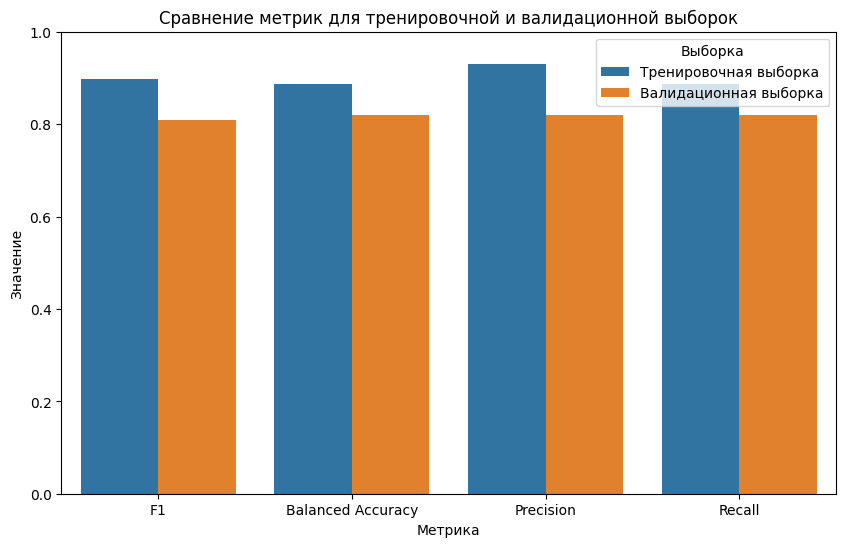

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Обучение с улучшенным бейзлайном

In [36]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", MyRandomForestClassifier())
))

In [37]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model',
                 <RForest.MyRandomForestClassifier object at 0x000001A3FEDFB250>)])

In [38]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

###  Оценка качества модели

In [39]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [40]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.931717,0.689815
1,Balanced Accuracy,0.930049,0.696296
2,Precision,0.938889,0.747222
3,Recall,0.930049,0.696296


Визуализация

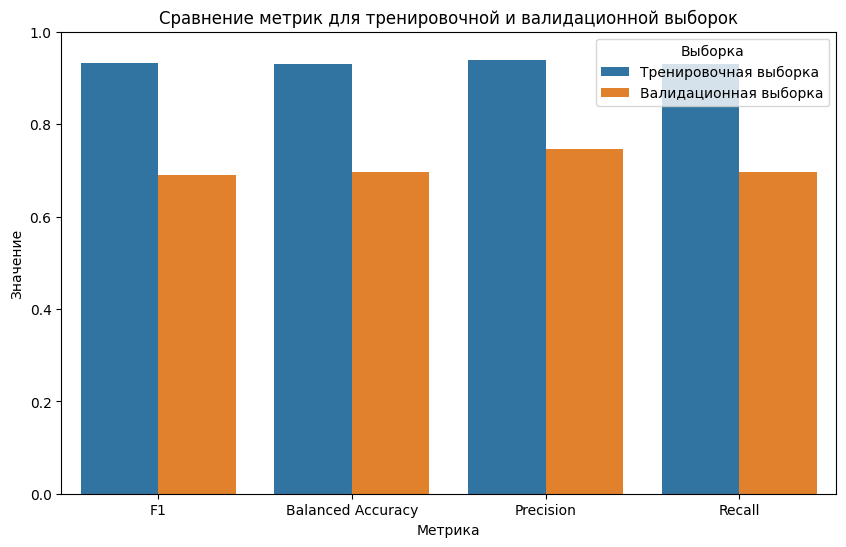

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()